# flowField class for iterative solution

---------------------------------------------------

## Inheriting numpy.ndarray()

Reference: http://docs.scipy.org/doc/numpy/user/basics.subclassing.html

## Defining flowField class that inherits np.ndarray

For starters, defining the class to initialize an empty ndarray along with a dictionary provided during initialization.

I need to verify that the dictionary being supplied has all the info I need to go with a flowField class. But, I can't verify this all the time. This is how I'll deal with it: 
* Verify the dictionary only when constructing a flowField class. So, that's when
    - Explicitly constructing an instance of the class
    - Viewing a given array as an instance of the class
* When slicing an array of the flowField class (to obtain another instance of the class), don't bother with the check. 

Basically, ensure every instance of the flowField class has a valid dictionary, and then stop worrying about it. 

So, we need a function that verifies the validity of dictionary, or creates one if one isn't supplied. The parameters required in the dictionary, and their defaults, are as follows:
* alpha : 1.14    
    *Wavenumber of fundamental streamwise Fourier mode*
* beta :  2.5    
    *Wavenumber of fundamental spanwise Fourier mode*
* omega: 0.0    
    *Fundamental frequency*
* ReLam: 400.0  
    *Reynolds number of the laminar base flow*
* isPois: 0     
    *Flag for base flow type. 0: Couette, 1: Poiseuille*
* noise: 0.0    
    *Norm of noise to be added to the flow*
* L: 0          
    *Number of (positive) harmonics of fundamental streamwise Fourier mode.*
* M: 0          
    *Number of (positive) harmonics of fundamental spanwise Fourier mode*
* N: 35         
    *Number of Chebyshev collocation nodes*
* K: 0         
    *Number of (positive) harmonics of fundamental frequency*

** For now, I'm ignoring the fact that np.ndarray can be viewed as a subclass. I'm defining the dictionary and checks in flowField.__new__(). Later, I'll have to move this to __array_finalize__ so that the dictionary is defined for cases when either an explicit constructor call is made or a view-casting is done**

### Ensure these features:
* View-casting:
    - ** View-casting a np.ndarray as flowField instance is not supported. Because view-casting does not allow any arguments, and the dictionary that accompanies the flowField array is fundamental. To make a flowField object out of an existing np.ndarray, use the constructor call. **
* Explicit construction:
    - Construct a randomField object based on noise levels supplied
* New from template:
    - Truncate and expand an instance of flowField to obtain a new instance with a changed dictionary (to reflect the truncation of L,M,N, or K)

***Try to minimize making copies of flowField objects***

** I have three cases to consider when building a flowField instance. Suppose L = 1**:
- The flowField has streamwise wavenumbers $-\alpha, 0, \alpha$
- The flowField only has streamwise wavenumbers $-\alpha, \alpha$
- The flowField only has streamwise wavenumber $\alpha$
    
This question becomes particularly important if only a half-plane or half-volume of the wavenumber space is considered. 

This is how I chose to resolve this issue. Considering L:
* If L = 0, then the flowField is of wavenumber $\alpha$
* If L = n ($\in \mathbb{N}$), then the flowField is resolved in wavenumbers {$0,\alpha,2\alpha,..,n\alpha$}.
* If L = -n ($n \in \mathbb{N}$), then the flowField is resolved in wavenumbers {$-n\alpha, (-n+1)\alpha,..,0,\alpha,...,n\alpha$}

This way, a flowField can be defined in three different ways for each of the three Fourier axes (streamwise, spanwise, temporal):
* As just one Fourier mode, $\alpha$ (which could be positive, negative, or zero). 
* As a collection of `n` harmonics (positive integer multiples of a positive/negative wavenumber), along with mode zero (the invariant mode).
* As a collection of `2n+1` harmonics, from $-n\alpha$ through $n\alpha$.

** Correction: For streamwise and temporal Fourier modes, the flowField class does not allow having just positive modes. We either have just one wavenumber (initialized with L=0 and/or K=0), of have 2L+1 and 2K+1 wavenumbers with both positive and negative**

I think this should be enough to deal with most cases. We will later need to define collections of flowFields. 

## Slice
I'm defining `slice` as a general method used for either truncating or extending the existing flowField instance. 

There are several cases to consider:
1.  Both existing and requested instances have the same wavenumber extension: either both contain positive and negative wavenumbers, or both contain only non-negative wavenumbers. For this case, there are 2 subcases:
    1.  The requested instance needs the existing instance to be truncated or held the same.
    2.  The requested instance needs the existing instance to be extended.
2.  The existing instance contains positive as well as negative wavenumbers, whereas the requested instance is only for positive wavenumbers. For this case:
    1.  The requested instance requires truncation in positive modes of the existing instance.
    2.  The requested instance requires extension in positive wavenumbers (with zeros for modes unavailable).
3.  The existing instance contains only positive wavenumbers, whereas the requested instance is for positive as well as negative. For this case too:
    1.  Truncation.
    2.  Extension.


## Going from half plane/volume to full using conjugate
I thought that if the Fourier modes available were $(0:K\omega,0:L\alpha, 0:M\beta)$, I could extend each set of modes into the negative side. But that's not true, I can only do that for just 1 set of modes. That is, I can't extend a quadrant to a full plane or an octant to a full volume. I can only go from 2 quadrants to 4, or 4 octants to 8. 

For now, I will suppose that we always have the flow resolved in the half-plane or the half-volume $\beta>0$. So, K,L are always negative (-0=0). Only M is allowed to be positive, but it could also be set to be negative. 

**With this simplification, cases 2 and 3 identified for slicing (above) only relate to M. For K and L, it's always case 1.**



## Linearizing convection term about a base flow

$\chi = \chi_b + \chi_f$ 
    where $\chi_b$ is the base flow and $\chi_f$ the perturbation


$\begin{align}
(\chi.\nabla)\chi &= ((\chi_b+\chi_f).\nabla)(\chi_b+\chi_f)\\
        &\approx \chi_b.\nabla \chi_b + \chi_b.\nabla \chi_f + \chi_f.\nabla \chi_b \\
\implies (\chi.\nabla)\chi - (\chi_b.\nabla)\chi_b &= \chi_b.\nabla \chi_f + \chi_f.\nabla \chi_b = C_l
\end{align}$ 

With the domain transformation stuff, the non-linear terms for stability analysis is going to be a pain to deal with- because when the fluctuation has a wavenumber which isn't an integral multiple of the surface wavenumber, the nice Fourier resolution that I have going right now will get messed up. For today, I'll do this part without worrying about the domain transformation. Just plain old LSA. 

Supposing $\chi_b = [U(y),0,0]$, with $\chi_f = [u_f(y), v_f(y), w_f(y)] e^{i(\alpha x + \beta z - \omega t)}$, and dropping the subscript 'f' henceforth:

$C_l[0] = U u_x + v U' \\
C_l[1] = U v_x \\
C_l[2] = U w_x $

## Dot products for different flowField instances

Inner products are defined as follows (supposing, WLG, only 2D scalars):

$\begin{align}
u^1(x,y) &= \Sigma_l u^1_l(y) e^{il\alpha_1 x}\\
u^2(x,y) &= \Sigma_m u^2_m(y) e^{im\alpha_2 x}\\
<u^1, u^2> &= \\
\end{align}$

## Adapting flowField class for transformed domains

My initial plan was to do something like this
    * Define flowField.ddx(), .ddy(),..., along with .grad(), .laplacian(), etc..
    * Have keyword arguments passed to .grad(), etc.. that refer to the partial derivatives. For flat-walled flows, the keyword arguments default to .ddx(), .ddy(), .ddz()
    * For transformed domains, pass functions other than the default .ddx(), etc.. to reflect the coordinate transformation. For instance, pass partialX = self.ddx() + Tfun*self.ddy()


But I think that would complicate things a bit too much. So, new strategy:
    * No keyword arguments for .grad(), etc... They always call self.ddx(), self.ddy(), self.ddz().
    * Overload .ddx(), .ddy(), .ddz() in the subclass of flowField

If I make methods such as .grad() use self.ddx() instead of flowField.ddx(), then then the overloaded methods would be used. That's all I need. 

## Making uBase more generic

The current version of the code takes uBase to be just [$u_{000}$(y), 0,0]. 

I need to extend this to more general cases, either for domain transformation or for higher classes of base flows, where uBase is a bigger vector with 3C along different Fourier modes. 

## Adding attributes kArr, lArr, mArr

Currently, the default for Fourier mode wavenumbers is integer multiples of $\omega, \alpha,\beta$. So, whenever a partial derivative along x,z, or t is requested, I create `kArr`, `lArr`, and `mArr` as arrays of integers. 

But for domain transformation problems, there are two length scales- the scale of the field variables (especially for fluctuations), and the scale of the surface-waviness. When these two length scales are not low integer multiples, I will have to have `kArr`, `lArr`, and `mArr`with non-integer entries. The simplest way to implement this, that I can think of right now, is to define the arrays as attributes of the flowField during initialization.

For the domain transformation cases, I can initialize using the default integer arrays, and then add a constant to reflect the wavenumber of the field variable. 

## Introducing kOffset, lOffset, mOffset instead of kArr, lArr, mArr

The reason that I wanted to introduce kArr, lArr, mArr above was so the class could deal with, most importantly, the following case:
    If a fluctuation with wavenumbers that are not integer multiples of the wavenumbers of the existing base flow is introduced, its energy would disperse (linearly) into wavenumbers that are, again, not integer multiples of wavenumbers of the base flow. 
    
But, the dispersion would only be into wavenumbers that are offset by a constant amount. 

To illustrate, suppose the base flow has modes of wavenumbers (-3a,-2a,-a,0,a,2a,3a). If a fluctuation of wavenumber 1.3a is introduced, its energy would disperse linearly (due to the base flow) into wavenumbers(-1.7,-0.7,0.3,1.3,2.3,3.3,4.3)a. 

Even for wavy walled flows, the above relation holds as long as only solutions periodic in surface waviness are considered. 

Instead of defining an lArr to indicate the wavenumbers to which energy has dispersed, I can simply say that it's still the same (-3,-2,-1,0,1,2,3)a, except with an offset of 1.3a. 

## Testing flowField class with exact solutions 

In [ ]:
import scipy as sp
import numpy as np
from pseudo import *

f = np.genfromtxt('eq1.asc',dtype=np.complex)
f_p = np.genfromtxt('peq1.asc',dtype=np.complex)
   
x = f[:,3];x_p = f_p[:,3]

# From the database at channelflow.org
Re=4.0e2
a=1.14
b=2.5

nx = 48
nz = 25
L = 24
M = 24
N = 35

# In input file, ordering of modes is different from what I would like it to be.
# It goes, 0,1,..,24,-23,-22,....,-1 in 'x'
# I prefer, -23,-22,..,-1,0,1,...,22,23
# In 'z', it's just 0,..,24 
#     Negative wavenumbers are not included due to symmetry.

# First, getting rid of mode 24 in both x and z 
modes = x.reshape((nx,nz,3,N))
modes = sp.append(modes,x_p.reshape((nx,nz,1,N)),axis=2)
modes = sp.delete(modes,L,0)
modes = sp.delete(modes,M,1)


nx = nx-1 
nz = nz-1
L = L-1
M = M-1

# Now, reordering streamwise wavenumbers
modes = sp.append(modes[L+1:,:,:,:],modes[:L+1,:,:,:],0)
del x,x_p,f,f_p


# Projecting Cheb coefficients onto Cheb collocation nodes
for kx in range(0,nx):
    for kz in range(0,nz):
        for nd in range(0,4):
            modes[kx,kz,nd,:] = chebcoll_vec(modes[kx,kz,nd,:])

# Adding modes for negative spanwise wavenumbers. 
#modes = sp.append(sp.append(modes[:15:-1,:0:-1,:,:].conjugate(),modes[15::-1,:0:-1,:,:].conjugate(),axis=0),modes,axis=1)
modes = sp.append(modes[::-1,:0:-1].conjugate(),modes,axis=1)
nz = nx

#modes = modes[15:nx-15, 15:nz-15,:,:]
#nx = nx-30
#nz = nz-30
#L = L-15
#M = M-15


#p_temp = modes[:,:,3]
## Removing boundary nodes:
#modes = sp.delete(modes,(0,N-1),3)

# Deleting pressure from state-vector:
p = modes[:,:,3]
modes = sp.delete(modes,3,2)

## Deleting wall-normal velocity from state-vector:
# v = modes[:,:,1,:]
# modes = sp.delete(modes,1,2)

## Defining wall-normal grid, and differentiation matrices
#y,DM = chebdif(N,2)
#D = DM[:,:,0]
#D2 = DM[:,:,1]

vecsize = nx*nz*N
# Finally, reshaping to get a state-vector containing u and w
x0 = modes.reshape(3*vecsize)
p = p.reshape(vecsize)
del modes
#print(modes[L,M,0])


## Reading data from .mat files into flowFieldArray class instance
Makes it easier to calculate variables, and to plot

1. Reading .mat files from a folder, according to a template, into a Python list
2. Converting that Python list into flowFieldArray instance (class defined in module flowFieldArray.py)

In [1]:
# Reading all the .mat files takes a while, so this chunk of code needs to be separate from the other stuff
import glob
import os
from flowFieldWavy import *
from flowFieldArray import *
from flowField import *

# These two lines allow iPython to reload modules before executing
%load_ext autoreload
%autoreload 2

theta='0'
homeFolder = '/home/sabarish/Dropbox/gitwork/python3/flowField/'
folderPath = '/home/sabarish/matData/drag/'
fileTemplate = "data_dragT"+theta+"E*.mat" 

os.chdir(folderPath)
fileList = glob.glob(fileTemplate)
for file in fileList[:]:
    if (file[-6:] =='13.mat') or (file[-6:] =='14.mat') or (file[-6:] =='15.mat'):
        #print(file)
        fileList.remove(file)

vListLong =[]; pListLong = []
for file in fileList:
    vList,pList = data2ff(file)[:2]
    vListLong.extend(vList)
    pListLong.extend(pList)
os.chdir(homeFolder)

In [2]:
#from flowFieldWavy import *
# Create flowFieldArray instance out of the list of flowField instances
vArr = flowFieldArray(vListLong,26,24,21)

print(isinstance(vArr[0,0,0].field, flowField))
# To obtain a 3-d array of, say, volume fluxes of the data in the flowFieldArray:
fluxArr = vArr.getProperty('flux',withBase=True)
#ReTauArr = vArr.getProperty('ReTau')


True


In [3]:
#ReTauArr = vArr.getProperty('ReTau')
ReArr = vArr.getProperty('Re')
#fluxArr = vArr.getProperty('flux',withBase=True)
uBulk = fluxArr; ReFlat = ReArr
print(ReFlat.shape, uBulk.shape, type(ReFlat), type(uBulk))
fricFac = 16./ReFlat/uBulk/uBulk
ReWavy = uBulk*ReFlat

(26, 24, 21) (26, 24, 21) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Curve fitting

- We're looking for a relation that goes as $\lambda = a Re^{-n}$, where $a$ and $n$ are functions of $g,\epsilon$. 
- From earlier work by Adrien, we know $n \approx 1$ for $\epsilon$ holds for $4\epsilon$ not exceeding 15%.
- We just need to verify if $\lambda Re = const.$ holds up, and if it does, how we need to see how the constant varies with $g,\epsilon$.

### FIrst, checking if the inverse law holds

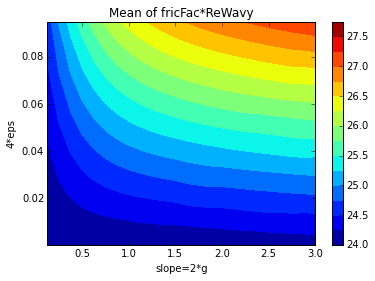

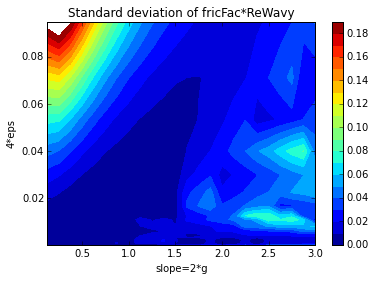

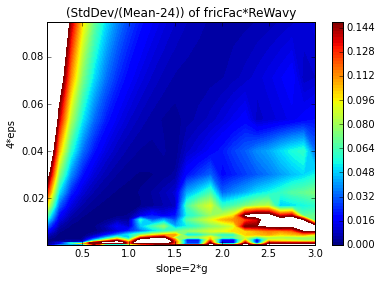

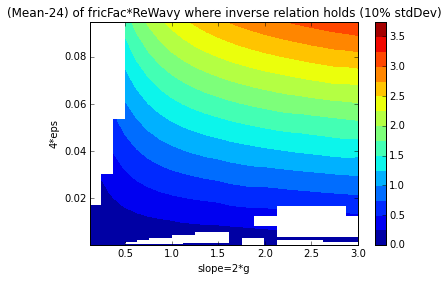

In [4]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
#coloring = np.random.random(32).reshape((8,4))
#for k in range(0,8):
#    plt.scatter(np.log10(ReWavy[3*k,3*k]),10.**(np.log10(ReWavy[3*k,3*k])+ np.log10(fricFac[3*k,3*k])), c=coloring[k-3])
#plt.ylim([-0.006,0.])
#plt.show()

#theta='0'
pp = PdfPages('InverseLaw'+theta+'.pdf')

prod = fricFac*ReWavy         # This must be a constant for different ReWavy. 
# To see if it is indeed constant, I can look at the standard deviation at any g,eps:

stdDev = np.std(prod,axis=2)  # Computing standard deviation for lambda*Re at a constant g,eps, but varying Re

epsArr = vArr.getProperty('eps')
gArr = vArr.getProperty('g')
cutOff = 5

cLimits = np.arange(24., 28., 0.25)
meanProd = np.mean(prod,axis=2)  # Computing mean for lambda*Re at a constant g,eps, but varying Re
plt.figure()
plt.contourf(2.*gArr[:-cutOff,:,0], 4.*epsArr[:-cutOff,:,0], meanProd[:-cutOff],levels=cLimits)
#plt.clim(24.0,28.0)
plt.colorbar()
plt.title('Mean of fricFac*ReWavy')
plt.xlabel('slope=2*g');plt.ylabel('4*eps')
#pp.savefig()
plt.savefig('meanT'+theta+'.pdf',format='pdf')
plt.show()

cLimits= np.arange(0.0, 0.2, 0.01)
plt.figure()
plt.title('Standard deviation of fricFac*ReWavy')
plt.contourf(2.*gArr[:-cutOff,:,0], 4.*epsArr[:-cutOff,:,0], stdDev[:-cutOff], levels=cLimits)
#plt.clim(0.0,0.2)
plt.colorbar()
plt.xlabel('slope=2*g');plt.ylabel('4*eps')
pp.savefig()
plt.savefig('stdT'+theta+'.pdf',format='pdf')
plt.show()


cLimits = np.arange(0.0,0.15,0.1/50)
plt.figure()
plt.title('(StdDev/(Mean-24)) of fricFac*ReWavy')
plt.contourf(2.*gArr[:-cutOff,:,0], 4.*epsArr[:-cutOff,:,0], stdDev[:-cutOff]/(meanProd[:-cutOff]-24),levels=cLimits)
#plt.clim(0.0,0.1)
plt.colorbar()
plt.xlabel('slope=2*g');plt.ylabel('4*eps')
plt.savefig('stdOverMeanT'+theta+'.pdf',format='pdf')
plt.show()
#plt.savefig('stdOverMeanT'+theta+'.pdf')

# Mean where stdDev/(mean-24) is small enough (<10%):
cLimits = np.arange(0., 4., 0.25)
stdOverMean = stdDev/(meanProd-24.)
newMean = meanProd.copy()
newMean[stdOverMean>0.1] = None
plt.figure()
plt.title('(Mean-24) of fricFac*ReWavy where inverse relation holds (10% stdDev)')
plt.contourf(2.*gArr[:-cutOff,:,0], 4.*epsArr[:-cutOff,:,0], (newMean[:-cutOff]-24), levels=cLimits)
plt.colorbar()
plt.xlabel('slope=2*g');plt.ylabel('4*eps')
plt.savefig('meanInverseLaw'+theta+'.pdf',format='pdf')
plt.show()


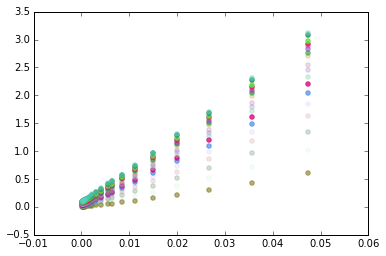

In [6]:
plt.figure()
lArr = np.random.rand(120).reshape(30,4)
'''
for k in range(21):
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    plt.scatter(2.*gArr[k,:,0],(meanProd[k,:]-24.), color=lArr[k])
plt.show()
'''
for k in range(21):
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    plt.scatter(2.*epsArr[:-5,k,0],(meanProd[:-5,k]-24.), color=lArr[k])
plt.show()


[ 12.50683108  20.80762158  27.64454164  33.42100507  38.19590511
  42.12675774  45.32643731  47.99816497  50.10347333  51.94045847
  53.51088467  54.94544126  56.30703368  57.42041514  58.37569486
  59.3496782   60.21365541  60.90453633  61.61807538  62.23502479
  62.8822363   63.54461036  63.93397671  64.40020013]
[-0.01139371 -0.01287589 -0.01102307 -0.00843385 -0.00458618 -0.00064789
  0.00425032  0.00810853  0.01646425  0.0220125   0.02755213  0.03007122
  0.03596523  0.04114871  0.047957    0.04805373  0.05248527  0.06035201
  0.06276786  0.06949728  0.07201174  0.0758987   0.0791079   0.08114705]


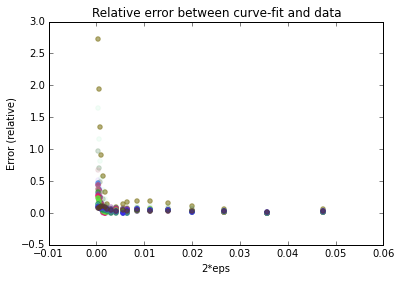

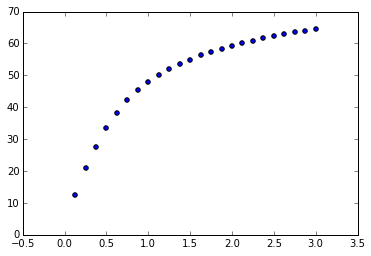

In [16]:
# Curve-fitting 'eps' dependence as a linear function using scipy.optimize.curve_fit:
from scipy.optimize import curve_fit
epsArrNew = epsArr[:-5]
epsVec = epsArrNew[:,0,0]
def linFun(xdata, a,b):
    return a*xdata+b

meanData = meanProd[:-5]-24.
aArr = np.zeros(meanData.shape[1]); bArr = np.zeros(aArr.shape); pErr = np.zeros((aArr.size,24))
for k in range(aArr.size):
    pOpt, pCov = curve_fit(linFun, 2.*epsVec, meanData[:,k],p0=[70.,0.])
    aArr[k],bArr[k] = pOpt

pCov
#print(pOpt,pCov)
print(aArr)
print(bArr)

gVec2 = 2.*gArr[0,:,0]
for k in range(meanData.shape[1]):
    plt.scatter(2.*epsVec[3:], np.abs(linFun(2.*epsVec[3:],aArr[k], bArr[k])-meanData[3:,k])/(meanData[3:,k]),color=lArr[k])
plt.title('Relative error between curve-fit and data ')
plt.xlabel('2*eps'); plt.ylabel('Error (relative)')
#plt.scatter(gVec2, meanData[k]-24.)
#plt.ylim([0.,0.2])
plt.show()

plt.figure()
plt.scatter(gVec2, aArr); plt.show()

[ 0.11608963  0.13281488  0.1409879   0.1487902   0.15466336  0.17375675
  0.21646057  0.30148946  0.32134166  0.32392644  0.32665577  0.36034396
  0.40419445  0.44626799  0.53211261  0.68496357  0.88220569  1.16725749
  1.51634504  2.01045067  2.68136749]
[ 0.62744808  0.57835959  0.54159673  0.49989779  0.4727498   0.4028756
  0.30828679  0.2197016   0.238661    0.28070185  0.35467098  0.4223748
  0.55122815  0.57621     0.71710097  0.75095575  0.79647828  0.79471817
  0.85139159  0.8520481   0.85561779]
[ -1.61809126e-02  -1.82933098e-02  -1.78297087e-02  -1.53356483e-02
  -1.18484232e-02  -7.03418678e-03  -2.33040123e-04   7.74216731e-03
   1.32285663e-02   2.15741602e-02   3.00369623e-02   4.17130533e-02
   4.68516536e-02   5.39352571e-02   5.91627034e-02   8.03454073e-02
   1.07066061e-01   1.55532940e-01   2.07747181e-01   3.10895271e-01
   4.62468207e-01]


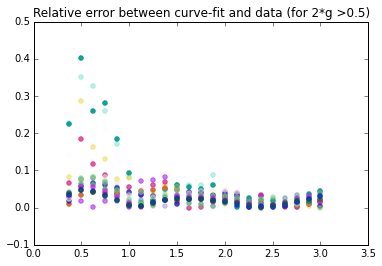

0.25


In [76]:
# Curve-fitting 'g' dependence as tanh() using scipy.optimize.curve_fit:
from scipy.optimize import curve_fit

def tanh(xdata, a,b,c):
    return a*np.tanh(b*xdata)+c

meanData = meanProd[:-5]-24.
aArr = np.zeros(meanData.shape[0]); bArr = np.zeros(aArr.shape); pErr = np.zeros((aArr.size,24))
cArr = np.zeros(aArr.shape)
for k in range(aArr.size):
    pOpt, pCov = curve_fit(tanh, 2.*gArr[0,:,0], meanData[k],p0=[1.,1.,0.])
    aArr[k],bArr[k],cArr[k] = pOpt

pCov
#print(pOpt,pCov)
print(aArr)
print(bArr)
print(cArr)


gVec2 = 2.*gArr[0,:,0]
for k in range(meanData.shape[0]):
    plt.scatter(gVec2[2:], np.abs(tanh(gVec2[2:],aArr[k], bArr[k],cArr[k])-meanData[k,2:])/(meanData[k,2:]),color=lArr[k])
plt.title('Relative error between curve-fit and data (for 2*g >0.5)')
#plt.scatter(gVec2, meanData[k]-24.)
#plt.ylim([0.,0.2])
plt.show()
print(gVec2[1])

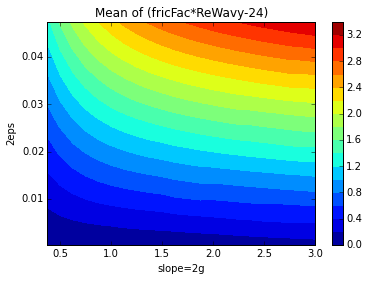

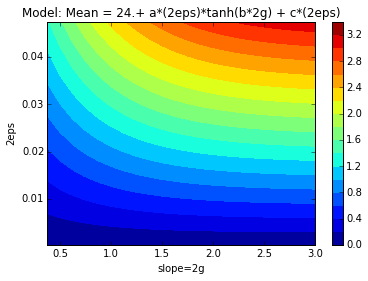

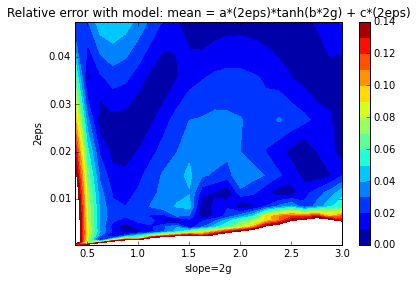

Model coefficients:a=52.404,b=0.715,c=15.274


In [60]:
from scipy.optimize import leastsq

meanData = meanProd[2:-5, 2:]-24.
epsVec2 = 2.*epsArr[2:-5,0,0]; gVec2 = 2.*gArr[0,2:,0]
eps2d = 2.*epsArr[2:-5,2:,0]; g2d = 2.*gArr[2:-5,2:,0]
eps1d = eps2d.reshape(eps2d.size); g1d = g2d.reshape(g2d.size)
meanData1d = meanData.reshape(meanData.size)

def __residuals(params,meanData1d,eps1d, g1d):
    # Fitting meanData to  a*tanh(b*g2d)*eps2d +c*eps2d
    # a = params[0]; b=params[1]; c=params[2]
    #print(params)
    residual = params[0]*np.tanh(params[1]*g1d)*eps1d + params[2]*eps1d - meanData1d
    #print ((type(residual)))
    return residual

#print(meanData.shape, eps2d.shape, g2d.shape)
#test = __residuals([70.,1.,10.], meanData, eps2d, g2d)
#print(type(test),test.shape)
pSol = leastsq(__residuals, np.array([70.,1.,10.]), args=(meanData1d,eps1d,g1d))[0]

plt.figure()
plt.contourf(g2d, eps2d,  meanData, levels=np.arange(0.,3.5,0.2))
plt.colorbar()
plt.title('Mean of (fricFac*ReWavy-24)')
plt.xlabel('slope=2g'); plt.ylabel('2eps')
plt.show()

plt.figure()
plt.contourf(g2d, eps2d, __residuals(pSol, meanData,eps2d,g2d)+meanData, levels=np.arange(0.,3.5,0.2))
plt.colorbar()
plt.title('Model: Mean = 24.+ a*(2eps)*tanh(b*2g) + c*(2eps)')
plt.xlabel('slope=2g'); plt.ylabel('2eps')
plt.show()

plt.figure()
plt.contourf(g2d, eps2d, np.abs(__residuals(pSol, meanData,eps2d,g2d)/meanData), levels=np.arange(0.,0.15,0.01))
plt.colorbar()
plt.title('Relative error with model: mean = a*(2eps)*tanh(b*2g) + c*(2eps)')
plt.xlabel('slope=2g'); plt.ylabel('2eps')
plt.show()

print('Model coefficients:a=%1.3f,b=%1.3f,c=%1.3f'%(pSol[0],pSol[1],pSol[2]) )

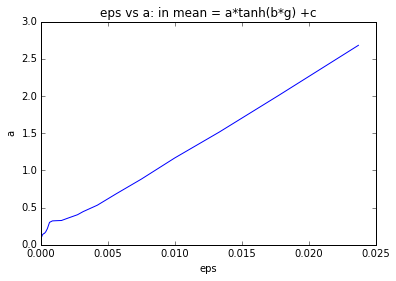

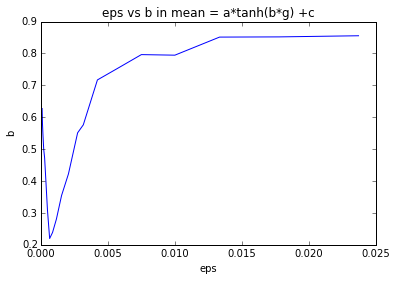

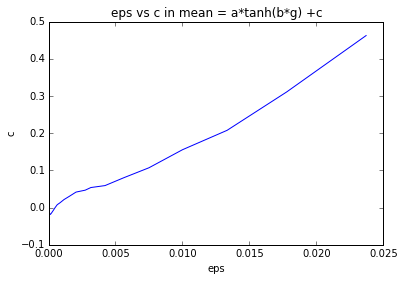

In [80]:
epsVec = epsArr[:-5,0,0]
plt.plot(epsVec,aArr)
plt.title('eps vs a: in mean = a*tanh(b*g) +c')
plt.xlabel('eps'); plt.ylabel('a');plt.show()


plt.figure()
plt.plot(epsVec,bArr)
plt.title('eps vs b in mean = a*tanh(b*g) +c')
plt.xlabel('eps'); plt.ylabel('b');plt.show()

plt.figure()
plt.plot(epsVec,cArr)
plt.title('eps vs c in mean = a*tanh(b*g) +c')
plt.xlabel('eps'); plt.ylabel('c');plt.show()


In [82]:
linFun = lambda xData,k: k*xData
sqrtFun = lambda xData,k: k*np.sqrt(xData)

aCoeff,pcov = curve_fit(linFun,epsVec, aArr, p0=100.)
bCoeff,pcov = curve_fit(sqrtFun, epsVec,bArr)
cCoeff,pcov = curve_fit(linFun, epsVec, cArr,p0=20.)

print(aCoeff, bCoeff,cCoeff)

[ 115.454474] [ 7.91223011] [ 17.67205961]


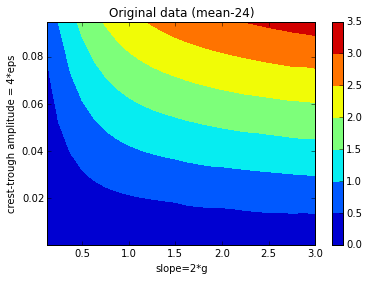

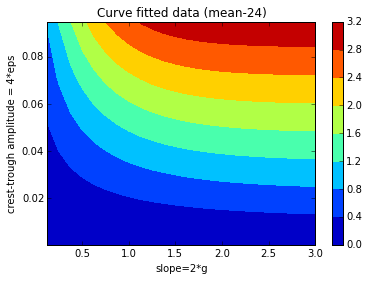

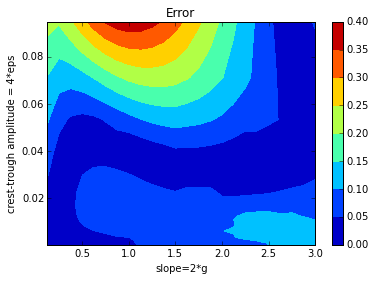

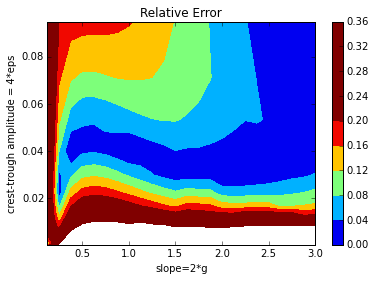

In [92]:
epsArr2 = epsArr[:-5,:,0]; gArr2 = gArr[:-5,:,0]
curveFitted = 24.+ cCoeff*epsArr2 + aCoeff*epsArr2*np.tanh(bCoeff*np.sqrt(epsArr2)*2.*gArr2)
originalData = meanProd[:-5]

plt.contourf(2.*gArr2, 4.*epsArr2,originalData-24.)
plt.title('Original data (mean-24)')
plt.xlabel('slope=2*g'); plt.ylabel('crest-trough amplitude = 4*eps')
plt.colorbar(); plt.show()


plt.figure()
plt.contourf(2.*gArr2, 4.*epsArr2, curveFitted-24.)
plt.title('Curve fitted data (mean-24)')
plt.xlabel('slope=2*g'); plt.ylabel('crest-trough amplitude = 4*eps')
plt.colorbar(); plt.show()

plt.figure()
plt.contourf(2.*gArr2, 4.*epsArr2, np.abs(curveFitted-originalData))
plt.title('Error')
plt.xlabel('slope=2*g'); plt.ylabel('crest-trough amplitude = 4*eps')
plt.colorbar(); plt.show()

plt.figure()
plt.contourf(2.*gArr2, 4.*epsArr2, np.abs(curveFitted-originalData)/(originalData-24.), levels = np.arange(0.,0.4,0.04))
plt.clim([0.,0.2])
plt.xlabel('slope=2*g'); plt.ylabel('crest-trough amplitude = 4*eps')
plt.title('Relative Error')
plt.colorbar(); plt.show()


## subclass of flowField: flowFieldWavy

For starters, define the class for geometries with just 1 surface wavenumber. Extend it later to cover arbitrary surfaces with multiple wavenumbers. 

The `alpha` and `beta` keys in the flowDict will give both the surface wavenumber and the periodicity of the flowfield being described. For laminar solutions, and possibly other exact solutions, this should suffice. For linear stability analysis, the `lOffset` and `mOffset` should do the job. 

With `alpha` and `beta` defined, the only parameter needed to define the surface geometry is `epsilon` (call it eps). 

The surfaces are defined as follows:
    
    y_surf = +/- 1 + 2*eps* cos(alpha*x + beta*z) = +/- 1 + eps*[ exp(i(alpha*x + beta*z)) + exp(-i(alpha*x + beta*z))]

In [47]:
from flowFieldWavy import *
vf,pf,fnorm = runMATLAB()

alpha is: 50.0


In [48]:
vf.verify(); pf.verify()
vf.printPhysicalPlanar(pField=pf, withBase=True)
print(vf.flowDict)

Printed physical field to file ffPlanar.dat
{'M': 0, 'beta': 0.0, 'L': 6, 'K': 0, 'isPois': 1, 'N': 60, 'noise': 0.0, 'omega': 0.0, 'alpha': 50.0, 'lOffset': 0.0, 'mOffset': 0.0, 'eps': 0.02, 'Re': 100.0, 'nd': 3}


In [64]:
from flowFieldWavy import *
vf,pf,paramDict = mapData2ff(eps=0.03)
vf.printPhysicalPlanar(pField=pf, withBase=False, fName='ffPlanar1')

Printed physical field to file ffPlanar1.dat


In [ ]:
L = vf.flowDict['L']; M = vf.flowDict['M']
vf[0,L+0,-M,1]

In [69]:
import numpy as np
from flowField import *
from flowFieldWavy import *

# eps = 10^(-3.+0.025*fileind)   => fileind = 40*(log10(eps) +3)
# g0 = [0.2:0.025:0.6]    => gind = 40*(g-0.2)
# g1 = [0.65:0.05:1.2, 1.3,1.4,1.5]   => gind = 20*(g-)
eps = 0.08/4.;  g = 2.0/2.; Re = 100

gFileInd = 0
gInd = int(40*(g-0.2))
if g> 0.6:
    gFileInd = 1
    gInd = int(20*(g-0.65))
    if gInd > 11: gInd = int((gInd-11)/2+11)
ReInd = np.int(np.log10(Re)-1)
        
eFileInd = 2*int(40*(np.log10(eps)+3)/2)

folderPath = '/home/sabarish/matData/seprn/'
fileName = 'dataSeprn'+str(gFileInd)+'b0_'+str(eFileInd)+'.mat'

#vfList, pfList,paramDict = data2ff(fName=folderPath+fileName,ind=gInd)
vf, pf,paramDict = data2ff(fName=folderPath+fileName,ind=3*gInd+ReInd)
eps = paramDict['eps']; g = paramDict['g']; Re = paramDict['Re']
printName = 'tecFiles/wavyE'+str(round(-np.log10(eps),2))+'G'+str(round(g,2))+'Re'+str(int(Re))+'.dat'
                                 
vf.printPhysicalPlanar(pField=pf, fName=printName)
#print(vf.getPhysical()- vf.getPhysical(xLoc=2.*np.pi/vf.flowDict['alpha']))
#print(vf.getScalar(nd=0).intY().getPhysical()-vf.getScalar(nd=0).intY().getPhysical(xLoc=np.arange(0.1,1.,0.1)))
#print(vf.getScalar(nd=0).intY().getPhysical())
#gArr = paramDict['g']
#ReArr = paramDict['Re']
#paramDict['g'][3:6]

Printed physical field to file tecFiles/wavyE1.7G1.0Re100.dat


## Need to redo separation plots for different `utol`

## Script for flow-vis: theta = 90

In [71]:
import numpy as np
from flowField import *
from flowFieldWavy import *

# eps = 10^(-3.+0.025*fileind)   => fileind = 40*(log10(eps) +3)
# g0 = [0.2:0.025:0.6]    => gind = 40*(g-0.2)
# g1 = [0.65:0.05:1.2, 1.3,1.4,1.5]   => gind = 20*(g-0.65)
eps = 0.03/4.;  g = 3.0/2.; Re = 1000
gFileInd = 0
gInd = int(40*(g-0.2))
if g> 0.6:
    gFileInd = 1
    gInd = int(20*(g-0.65))
    if gInd > 11: gInd = int((gInd-11)/2+11)
ReInd = np.int(np.log10(Re)-1)
        
eFileInd = 2*int(40*(np.log10(eps)+3)/2)

folderPath = '/home/sabarish/matData/seprn/'
fileName = 'dataSeprn'+str(gFileInd)+'b90_'+str(eFileInd)+'.mat'

#vfList, pfList,paramDict = data2ff(fName=folderPath+fileName,ind=gInd)
vf, pf,paramDict = data2ff(fName=folderPath+fileName,ind=3*gInd+ReInd)
eps = paramDict['eps']; g = paramDict['g']; Re = paramDict['Re']
printName = 'tecFiles/wavyB90E'+str(-np.log10(eps))+'G'+str(g)+'Re'+str(int(Re))+'.dat'
vf.printPhysicalPlanar(pField=pf, fName=printName)
#gArr = paramDict['g']
#ReArr = paramDict['Re']
#paramDict['g'][3:6]

Printed physical field to file tecFiles/wavyB90E2.15G0.0Re1000.dat


## Script for flow-vis: theta = 30

In [ ]:
import numpy as np
from flowField import *
from flowFieldWavy import *

# eps = 10^(-3.+0.025*fileind)   => fileind = 40*(log10(eps) +3)
# g0 = [0.2:0.025:0.6]    => gind = 40*(g-0.2)
# g1 = [0.65:0.05:1.2, 1.3,1.4,1.5]   => gind = 20*(g-0.65)
eps = 0.025/4.;  g = 2.0/2.; Re = 10
gFileInd = 0
gInd = int(40*(g-0.2))
if g> 0.6:
    gFileInd = 1
    gInd = int(20*(g-0.65))
    if gInd > 11: gInd = int((gInd-11)/2+11)
ReInd = np.int(np.log10(Re)-1)
        
eFileInd = 2*int(40*(np.log10(eps)+3)/2)

folderPath = '/home/sabarish/matData/'
fileName = 'dataSeprn'+str(gFileInd)+'b30_'+str(eFileInd)+'.mat'

#vfList, pfList,paramDict = data2ff(fName=folderPath+fileName,ind=gInd)
vf, pf,paramDict = data2ff(fName=folderPath+fileName,ind=3*gInd+ReInd)
eps = paramDict['eps']; g = paramDict['g']; Re = paramDict['Re']
printName = 'tecFiles/wavyB30E'+str(-np.log10(eps))+'G'+str(g)+'Re'+str(int(Re))+'.dat'
vf.printPhysicalPlanar(pField=pf, fName=printName)
#gArr = paramDict['g']
#ReArr = paramDict['Re']
#paramDict['g'][3:6]

## Solving riblet flow without coordinate transformation

The velocity, $u$, is expanded as

$a_0 + b_0 y + \sum_n [a_n e^{-ny} + b_n e^{ny}] e^{in\beta z}$

For each mode, there are two unknowns, a and b. The boundary conditions are that the velocity is zero at either wall. So, if I set the above expression to zero for some 'm' locations, and use 'm' modes (including zero), I can simply invert the coefficient matrix to obtain all the 'a's and 'b's. 

In [ ]:
import numpy as np

b = 10. # beta
eps = 0.02
n = 21 # Number of positive modes
m = 2*n+1 # Total number of modes including zero



zArr = np.arange(0., 2.*np.pi/b-1.0e-9, 2.*np.pi/b/m)
yShape = 2.*eps*np.cos(b*zArr)
L = np.zeros((2*m, 2*m), dtype=np.complex)

yTop = (1.+yShape).reshape((yShape.size,1))
yBottom = -1.+yShape.reshape((yShape.size,1))
zArr = zArr.reshape((zArr.size,1))

expTopA = -yTop + 1.j*b*zArr
expTopB = yTop + 1.j*b*zArr
expBottomA = -yBottom + 1.j*b*zArr
expBottomB = yBottom + 1.j*b*zArr

nArr = np.arange(-n,n+1).reshape((1,m))

L[:m, :-1:2] = np.exp(nArr*expTopA)       # Factors multiplying a_n, for yTop locations
L[:m, 1::2] = np.exp(nArr*expTopB)       # Factors multiplying b_n, for yTop locations
L[m:, :-1:2] = np.exp(nArr*expBottomA)    # yBottom locations
L[m:, 1::2] = np.exp(nArr*expBottomB)

# For a_0, the factor is 1 = exp(0.) = exp(0.*y + 0.*1.j*b*z), so above assignment works
# For b_0, the factor is y, but the above assignment only assigns a factor of 1
# Correcting factors for b_0
L[:m, 2*n+1:2*n+2] += yTop - 1.
L[m:, 2*n+1:2*n+2] += yBottom - 1.

# To find the factors, a_n, b_n, the null-space of L needs to be found 
#           (since the boundary condition at yTop, yBottom is that velocity is zero)
# Before that, let's see what the rank is
print('Size of L[0]:', L.shape[0])
print('Rank of L is', np.linalg.matrix_rank(L))
np.linalg.null?

61122
Volume flux without base: -0.0610516590273
Volume flux with base: 1.27228167431
{'b': 0.0, 'fnorm': 4.468750654592215e-11, 'eps': 0.0199526231496888, 'g': 1.0, 'a': 50.11872336272722, 'Re': 100.0}
max U in readFOAMData(): 0.0139266
max u in uFoam: 0.0139266
max U velocity from foamData: 0.92844
a*xLoc/pi for symmetry:  [ 0.02634451  0.07903354  0.12585373  0.16608852  0.20525117  0.23994374
  0.27052182  0.3010999   0.33072189  0.35819955  0.38448897  0.41077838
  0.43692982  0.46245241  0.48748414  0.51251586  0.53754759  0.56307018
  0.58922162  0.61551103  0.64180044  0.66927811  0.6989001   0.72947818
  0.76005626  0.79474883  0.83391148  0.87414627  0.92096646  0.97365549]


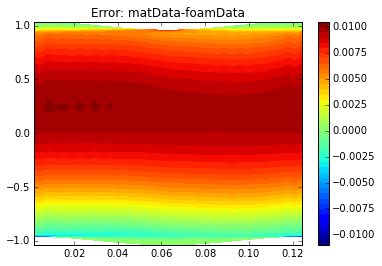

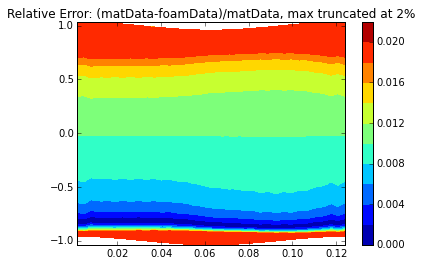

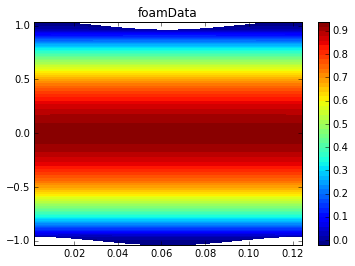

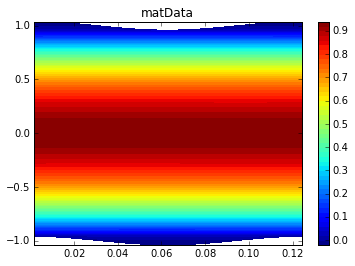

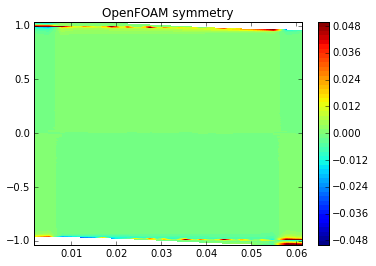

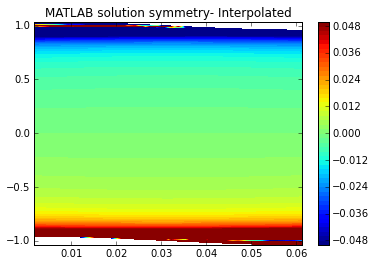

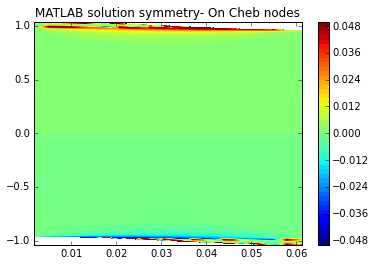

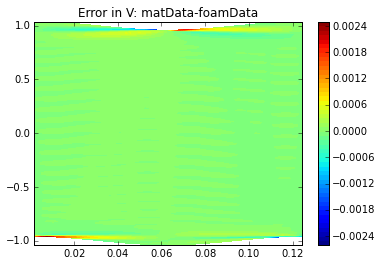

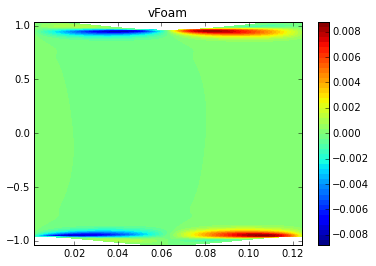

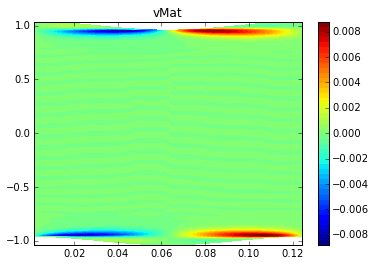

In [6]:
import numpy as np
from flowFieldWavy import *
from myUtils import *

filePath =  '/home/sabarish/OpenFOAM/sabarish-2.4.x/run/wavyLam/ep02/a50/finest/'
endTime = '560/'
pointsName=filePath+'constant/polyMesh/points'
eps = 0.02
a = 50
g= a*eps

x,y,z = readPoints(fName=pointsName, nx = 61,ny=501)
yMax =np.max(y)
yMin = np.min(y)
#h = (yMax-yMin)/2.08
h = 0.1
x = x/h; y =(y-h)/h; z=z/h

import matplotlib.pyplot as plt
%matplotlib inline
vF,pF,paramDict = mapData2ff(g=g, eps=eps, Re=100, theta=0)
print('Volume flux without base:', vF.flux())
print('Volume flux with base:',vF.flux(withBase=True))
print(paramDict)
u = vF.getScalar(nd=0)
v = vF.getScalar(nd=1)
uData = np.zeros(x.shape); vData = np.zeros(x.shape); uUnInt = np.zeros((x.shape[0],x.shape[1],u.N))
for kx in range(x.shape[0]):
    for kz in range(x.shape[1]):
        yBottom = np.min(y[kx,kz])
        yT = y[kx,kz]-yBottom-1.
        uData[kx,kz] = u.getPhysical(xLoc=x[kx,0,0], zLoc=z[0,kz,0], yLoc = yT,withBase=True)
        uUnInt[kx,kz] = u.getPhysical(xLoc=x[kx,0,0], zLoc=z[0,kz,0], withBase=True)
        vData[kx,kz] = v.getPhysical(xLoc=x[kx,0,0], zLoc=z[0,kz,0], yLoc = yT)
        
yUnInt = np.zeros((x.shape[0],u.N))
yCheb = chebdif(u.N,1)[0]
for kx in range(x.shape[0]):
    xLoc = x[kx,0,0]
    yUnInt[kx] = yCheb + 2.*u.flowDict['eps']*np.cos(u.flowDict['alpha']*xLoc)
        
#writeFOAMData(vF,pF)
#'''
uFoam,vFoam,wFoam = readFOAMData(fName=filePath+endTime+'U',nx=60,ny=500)
print('max u in uFoam:',np.max(uFoam))
uFoam = uFoam/0.015
vFoam = vFoam/0.015

plt.figure()
plt.title('Error: matData-foamData')
plt.contourf(x[:,0], y[:,0], uData[:,0]-uFoam[:,0], 50)
plt.colorbar()
plt.figure()
plt.title('Relative Error: (matData-foamData)/matData, max truncated at 2%')
uRel = np.abs((uData[:,0]-uFoam[:,0])/uData[:,0])
uRel[uRel>0.02] = 0.02; uRel[uRel<-0.02] = -0.02
plt.contourf(x[:,0], y[:,0],uRel , 10)
plt.colorbar()
plt.figure()
plt.title('foamData')
plt.contourf(x[:,0], y[:,0], uFoam[:,0], 50)
plt.colorbar()
print('max U velocity from foamData:',np.max(uFoam))
plt.figure()
plt.title('matData')
plt.contourf(x[:,0], y[:,0], uData[:,0], 50)
plt.colorbar()

plt.figure()
plt.title('OpenFOAM symmetry')
nx = x.shape[0]
u1 = uFoam[:nx//2,0]; u2 = uFoam[nx//2:,0,::-1]
udif = (u2-u1)/u1
udif[udif>0.05]=0.05; udif[udif<-0.05] = -0.05
plt.contourf(x[:nx//2,0], y[:nx//2,0],udif , 50)
plt.colorbar()

plt.figure()
plt.title('MATLAB solution symmetry- Interpolated')
nx = x.shape[0]
u1 = uData[:nx//2,0]; u2 = uData[nx//2:,0,::-1]
udif = (u2-u1)/u1
udif[udif>0.05]=0.05; udif[udif<-0.05] = -0.05
plt.contourf(x[:nx//2,0], y[:nx//2,0],udif , 50)
plt.colorbar()

plt.figure()
plt.title('MATLAB solution symmetry- On Cheb nodes')
nx = x.shape[0]
u1 = uUnInt[:nx//2,0]; u2 = uUnInt[nx//2:,0,::-1]
print('a*xLoc/pi for symmetry: ', a*x[:nx//2,0,0]/np.pi)
udif = (u2-u1)/u1
udif[udif>0.05]=0.05; udif[udif<-0.05] = -0.05
plt.contourf(x[:nx//2,0,:u.N], yUnInt[:nx//2],udif , 50)
plt.colorbar()


plt.figure()
plt.title('Error in V: matData-foamData')
plt.contourf(x[:,0], y[:,0], vData[:,0]-vFoam[:,0], 50)
plt.colorbar()
plt.figure()
plt.title('vFoam')
plt.contourf(x[:,0], y[:,0], vFoam[:,0], 50)
plt.colorbar()
plt.figure()
plt.title('vMat')
plt.contourf(x[:,0], y[:,0], vData[:,0], 50)
plt.colorbar()



plt.show()

#'''

### Checking symmetry of a MATLAB solution

In [2]:
from flowFieldWavy import *
import numpy as np
vF,pF = mapData2ff(eps=0.02,g=1.0,Re=100., theta=0)[:2]
a = vF.flowDict['alpha']
for x in np.arange(0.,np.pi/a,np.pi/a/21.):
    print(np.linalg.norm(vF.ifft(xLoc=x)[0] - vF.ifft(xLoc=x+np.pi/a)[0,::-1]) )
#print(vF.ifft(xLoc=0))

1.60125554082e-13
1.60112644336e-13
1.60084459486e-13
1.60042401126e-13
1.59982019586e-13
1.59904635808e-13
1.59901654358e-13
1.59916770834e-13
1.59962648591e-13
1.59790109011e-13
1.59831221832e-13
1.59708190707e-13
1.5977536299e-13
1.59932902939e-13
1.5973343672e-13
1.59897972038e-13
1.59886576258e-13
1.60055238894e-13
1.59960423239e-13
1.60105232668e-13
1.60111730526e-13
